In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from astropy.io import fits

In [2]:
from google.colab import drive #delete this if not on colab
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
data_folder = os.path.join('/content/drive/MyDrive/TOAFINAL') #folders where the data is
calib_folder = os.path.join(data_folder, 'raw', 'calib') #replace with your thing
bias_folder=os.path.join(calib_folder, 'bias')
flat_folder=os.path.join(calib_folder, 'flat')
dark_folder=os.path.join(calib_folder, 'dark')
science_folder=os.path.join(data_folder,'science')
#folder to save the reduced images
output_folder=os.path.join(data_folder,'reduced')

Calibration files separator (not required to run, could be improved to also do the science images by filter but not really needed with the amount of files i'm gonna be handling)



In [ ]:
# -*- coding: utf-8 -*-
   
source_dir = calib_folder #folder where all your unsorted files are

target_dirs=['bias','dark','Flat'] # names of the calibration foldes, would need to add an arc in the case of spectroscopy
 
file_names= [x for x in os.listdir(source_dir) if x not in target_dirs] #get a list of all the files, the if x not blablabla skips the folders in case you put them with the raw data

for folder in target_dirs: #we now scan for bias, dark, flat
     for file_name in file_names: #in each file
         header = fits.getheader(os.path.join(source_dir,file_name),0) #getting the header
         print(header['OBJECT']) #sanity check print, can comment
         if folder in header['OBJECT']: #and if the header contains the string 'bias', 'dark' or 'Flat'
             shutil.move(os.path.join(source_dir, file_name), os.path.join(target_dir,folder,file_name)) #we move it where it belongs
             file_names= [x for x in os.listdir(source_dir) if x not in target_dirs] #update the list so it doesn't complain
#The flats and the science images must be separated by filter in different folders for the next things to work
#small program to see which filter is which flat in the unsorted flat folder
for filename in os.listdir(flat_folder):
  if os.path.isdir(os.path.join(flat_folder,filename)): # skip directories
    continue
  header=fits.getheader(os.path.join(flat_folder,filename),0)
  print(filename, 'is', header['OBJECT'])


IsADirectoryError: ignored

Master Bias

Opening ABC0042.fits
Opening ABC0043.fits
Opening ABC0044.fits
Opening ABC0045.fits
Opening ABC0046.fits
Opening ABC0047.fits
Opening ABC0048.fits
Opening ABC0049.fits
Opening ABC0050.fits
Opening ABC0051.fits
Opening ABC0052.fits
Opening ABC0053.fits
Opening ABC0054.fits
Opening ABC0055.fits
Opening ABC0056.fits
Opening ABC0057.fits
Opening ABC0059.fits
Opening ABC0058.fits
Opening ABC0060.fits
Opening ABC0061.fits
20 files read
median bias=720.0, probability_uniform=1.0918666885648947e-19, (signal_variance=139.28, noise_variance=3.19


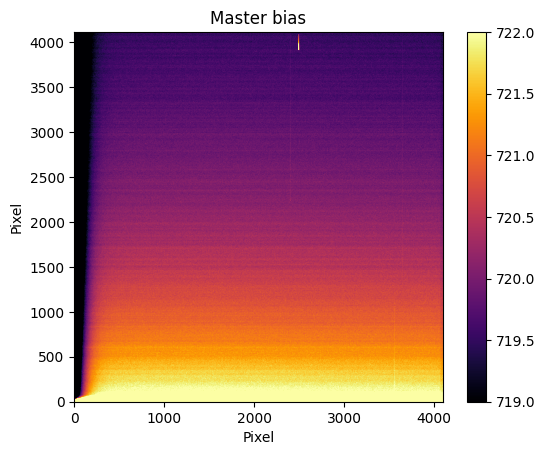

Master bias saved to /content/drive/MyDrive/TOAFINAL/raw/calib/bias/master_bias.fits


In [7]:
raw_bias_exposures = []  # list to put all the bias files in

for filename in os.listdir(bias_folder): 
    if filename=='master_bias.fits': #skip the master bias as it has no exp time
      continue   
    print("Opening", filename)
    hdu = fits.open(os.path.join(bias_folder, filename))  
    raw_bias_exposures.append(hdu[0].data)  #add the data to the list
    if hdu[0].header['EXPTIME'] > 0: #the bias has to be exposure zero so if it's not there's something wrong with the file
        raise FileNotFoundError("Non-null exposure time: t_exp = "+hdu[0].header['EXPTIME'])
   
n_files = len(raw_bias_exposures)
print(n_files, "files read")

bias_map = np.nanmedian(raw_bias_exposures, axis=0) #we take the median of all the biases
noise_map = np.nanvar(raw_bias_exposures, axis=0) #and the variance for the statistical check

# Test whether the median bias map is uniform  (from Yago)
map_median = np.nanmedian(bias_map)  # estimate of a uniform value accross the image
map_variance = np.nanvar((bias_map<2000)*1*bias_map)  # map_variance = signal_variance + noise_variance
#we shouldn't count the saturated pixels for the variance, hence the percentile
#for example here we have a median of 700 and the pixels that are 60000 screw the variance up
noise_variance = np.nanmedian(noise_map)  # median value of the readout noise
signal_variance = map_variance - noise_variance #estimate the actual variance of the signal
if signal_variance <= 0.: #if it doesn't change at all it must be uniform
    probability_uniform = 1.
else: #else we use an exponential distribution to get the probability of the signal being uniform
    probability_uniform = np.exp(-signal_variance/noise_variance)
uniform = map_median*np.ones_like(bias_map) #create a truly uniform signal with the median
print(f'median bias={map_median}, probability_uniform={probability_uniform}, (signal_variance={signal_variance:.2f}, noise_variance={noise_variance:.2f}')
bias_map = probability_uniform*uniform + (1-probability_uniform)*bias_map  # weighted average 
#in this case the uniform probability turned out to be zero so all of this wasn't really needed but i think it's nice to have

#plot the master bias
plt.imshow(bias_map, origin='lower', vmin=np.nanpercentile(bias_map, 5), vmax=np.nanpercentile(bias_map, 95), cmap='inferno')
plt.title('Master bias')
plt.xlabel('Pixel')
plt.ylabel('Pixel')
plt.colorbar()
plt.show()
bias_output_filename='master_bias.fits'
#saving the master bias
hdu = fits.PrimaryHDU(bias_map.astype(np.float32))
hdu.writeto(os.path.join(bias_folder,bias_output_filename), overwrite=True)
print("Master bias saved to", os.path.join(bias_folder,bias_output_filename))


Master dark: there were no dark data in this case, can skip. In the case where dark is relevant we have to
1. Subtract the bias to it
2. Take the median as we did before

In [17]:
dark=0 

#dark_exposures = [] 
#for filename in os.listdir(dark_folder):  # Loop over all files in the directory
#    print("Opening", filename)
#    hdu = fits.open(os.path.join(dark_folder, filename))  # HDU = Header/Data Unit (standard FITS nomenclature)
#    dark_exposures.append((hdu[0].data, hdu[0].header['EXPTIME']))

#n_files = len(dark_exposures)
#print(n_files, "files read")
#dark_map = np.nanmedian(raw_dark_exposures, axis=0)
#plt.imshow(dark_map, origin='lower', vmin=np.nanpercentile(dark_map, 5), vmax=np.nanpercentile(dark_map, 95))
#plt.title('Master dark')
#plt.colorbar()
#plt.show()
#hdu = fits.PrimaryHDU(dark_map)
#hdu.writeto(output_filename, overwrite=True)
#print("Master dark saved to", output_filename)

Master flat in each filter (the flats and the science images must be separated by filter in different folders for the next things to work)

Reading SDSS_g band flats:
 - Opening ABC0014.fits
 - Opening ABC0013.fits
 - Opening ABC0005.fits
 - Opening ABC0004.fits
 - Opening ABC0003.fits
 - Opening ABC0002.fits
 - Opening ABC0020.fits
 - Opening ABC0019.fits
 - 8 files read for SDSS_g band
Reading SDSS_r band flats:
 - Opening ABC0007.fits
 - Opening ABC0006.fits
 - Opening ABC0021.fits
 - Opening ABC0017.fits
 - Opening ABC0016.fits
 - Opening ABC0015.fits
 - 6 files read for SDSS_r band
Reading SDSS_i band flats:
 - Opening ABC0010.fits
 - Opening ABC0009.fits
 - Opening ABC0008.fits
 - Opening ABC0022.fits
 - Opening ABC0018.fits
 - 5 files read for SDSS_i band
Reading Hb band flats:
 - Opening ABC0011.fits
 - Opening ABC0037.fits
 - Opening ABC0032.fits
 - Opening ABC0025.fits
 - Opening ABC0024.fits
 - Opening ABC0023.fits
 - Opening ABC0012.fits
 - 7 files read for Hb band
Reading Ha band flats:
 - Opening ABC0038.fits
 - Opening ABC0033.fits
 - Opening ABC0027.fits
 - Opening ABC0026.fits
 - 4 files read for Ha band
R

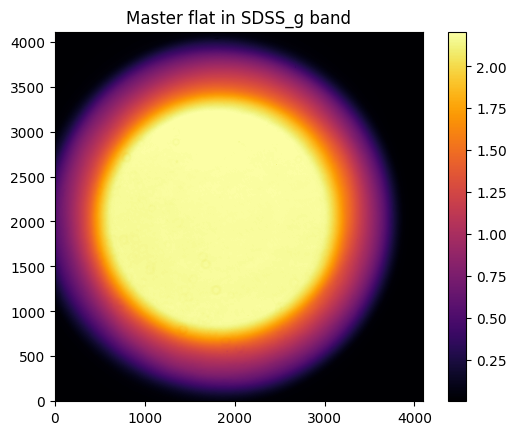

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_SDSS_g.fits


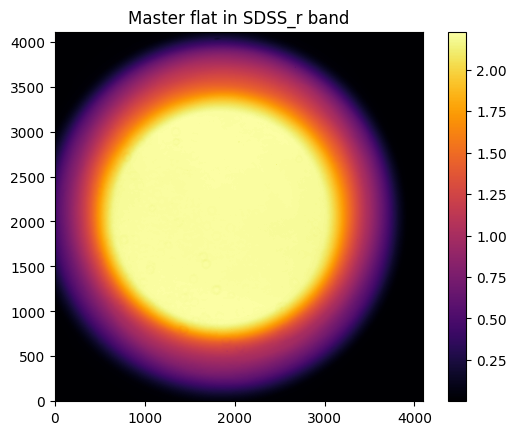

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_SDSS_r.fits


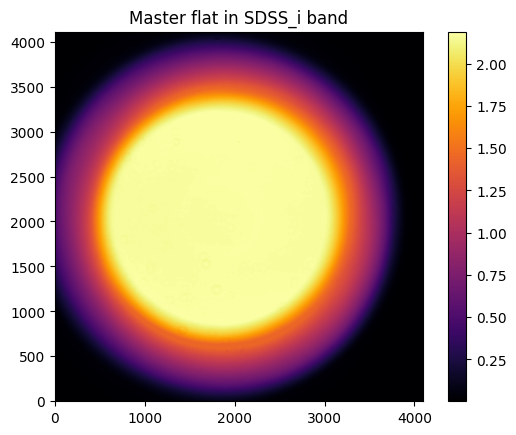

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_SDSS_i.fits


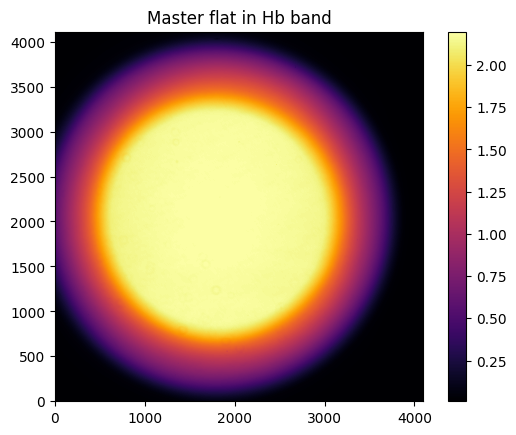

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_Hb.fits


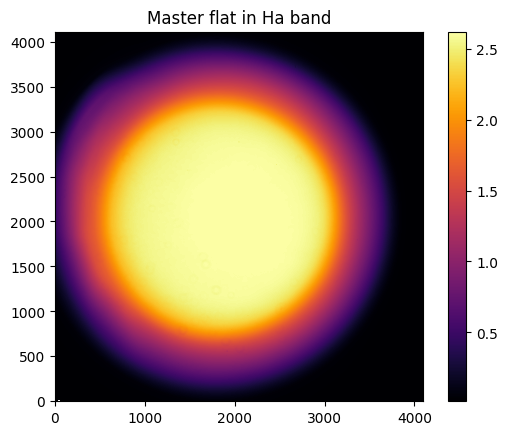

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_Ha.fits


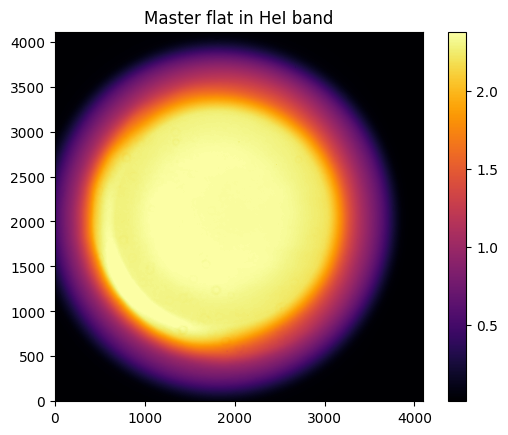

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_HeI.fits


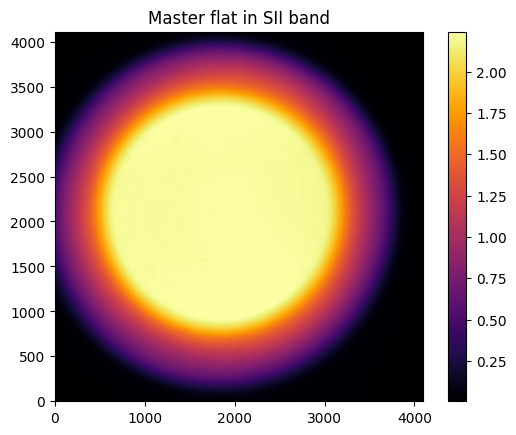

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_SII.fits


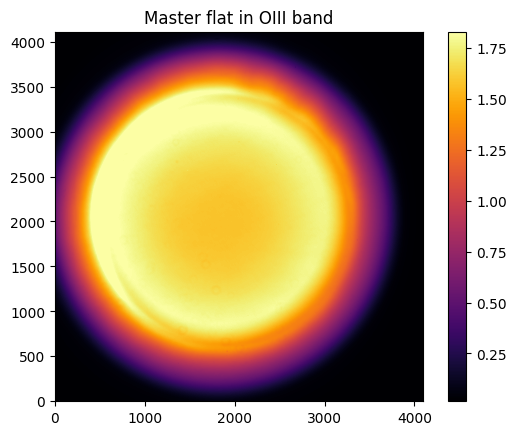

Master flat saved to /content/drive/MyDrive/TOAFINAL/raw/calib/master_flat_OIII.fits


In [18]:
#we need to subtract the bias and the dark to the flats, important
#check whether there is a master bias, if not set it =0
#CARFEUL: files ABC_0000 and 0001 have different resolution than all of the others for some reason, so i just deleted them
bias_output_filename='master_bias.fits'

if os.path.exists(os.path.join(bias_folder,bias_output_filename)): #reading the master bias
  hdu=fits.open(os.path.join(bias_folder,bias_output_filename))
  bias=hdu[0].data
else:
  bias=0
  print('Master bias not found, setting bias to zero')

flat_exposures = {}  # dictionary containing all flats, will separate by filter
filters_list=['SDSS_g','SDSS_r','SDSS_i','Hb','Ha','HeI','SII','OIII'] #list of all the filters, must be folders in flat_folder


for filter in filters_list:  # loop over all the filters
    if os.path.isdir(os.path.join(flat_folder, filter)): #check that there is actually a folder
        print("Reading", filter, "band flats:")
        flat_exposures[filter] = []  # empty list to store the exposures
        
        for filename in os.listdir(os.path.join(flat_folder, filter)):  # loop over all flats
            print(" - Opening", filename)
            hdu = fits.open(os.path.join(flat_folder, filter, filename))  
            exposure = hdu[0].data - bias - dark*hdu[0].header['EXPTIME'] #subtract the bias and the dark
            #add 1 to the pixels where the flats have zero counts to avoid divides by zero later (specific to this case)
            zeros=exposure==0 #where exposure is 0
            exposure=exposure+(zeros*1)
            flat_exposures[filter].append(exposure/np.nanmedian(exposure)) #normalize the flat dividing by the median and add it to the dictionary in the corresponding band
        n_files = len(flat_exposures[filter])
        print(" -", n_files, "files read for", filter, "band")

    else:
        print(filter+" is not a directory")


for filter in flat_exposures:
    flat_map = np.nanmedian(flat_exposures[filter], axis=0) #do the median on each filter to get the master flat
    bad_flat = np.abs(flat_map-1) > 5*np.nanstd(flat_map)  #sigma-clipping (from Yago), deletes some outliers
    flat_map[bad_flat] = np.nan
     ##plot
    plt.imshow(flat_map, origin='lower', vmin=np.nanpercentile(flat_map, 5), vmax=np.nanpercentile(flat_map, 95),cmap='inferno')
    plt.title('Master flat in '+filter+' band')
    plt.colorbar()
    plt.show()
    ##saving the flats
    output_filename = os.path.join(calib_folder, 'master_flat_'+filter+'.fits')
    hdu = fits.PrimaryHDU(flat_map)
    hdu.writeto(output_filename, overwrite=True)
    print("Master flat saved to", output_filename)

Combining everything

Read master flat for SDSS_g  band
Read master flat for SDSS_r  band
Read master flat for SDSS_i  band
Read master flat for Hb  band
Read master flat for Ha  band
Read master flat for HeI  band
Read master flat for SII  band
Read master flat for OIII  band
Opening ABC0003 (2).fits
ABC0003 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_g/ABC0003 (2).fits


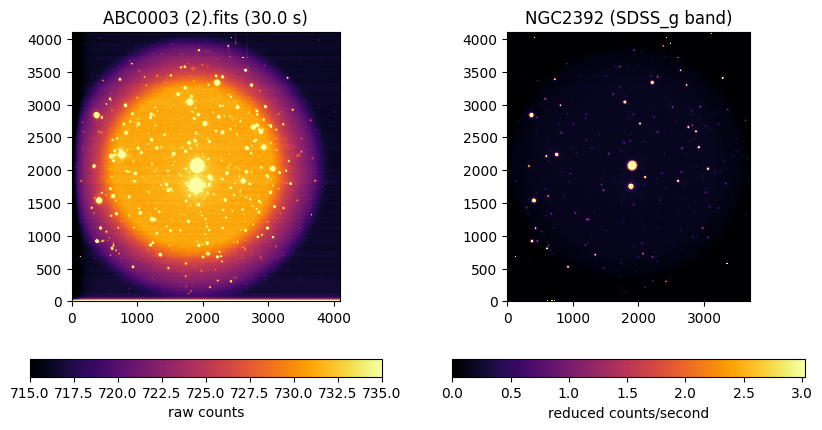

Opening ABC0005 (2).fits
ABC0005 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_g/ABC0005 (2).fits


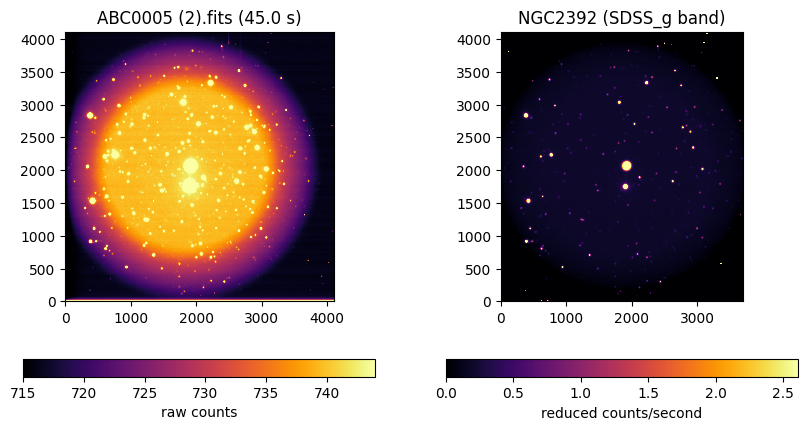

Opening ABC0006 (2).fits
ABC0006 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_g/ABC0006 (2).fits


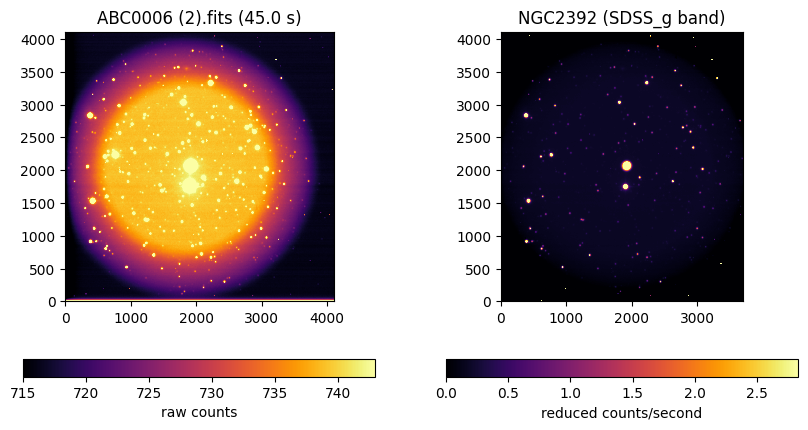

Opening ABC0004 (2).fits
ABC0004 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_g/ABC0004 (2).fits


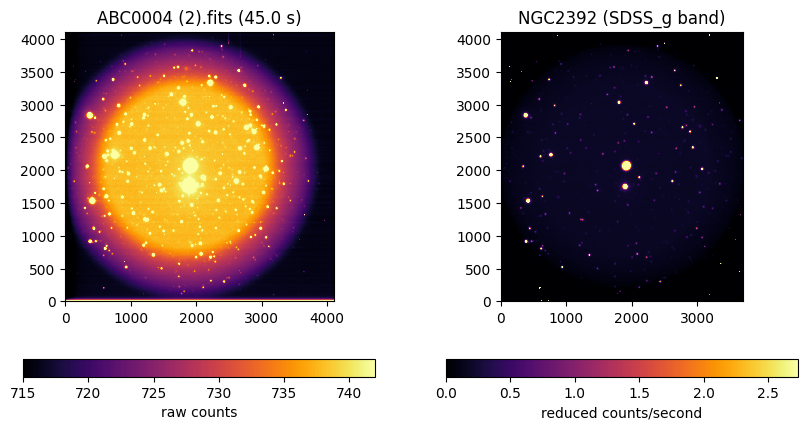

Opening ABC0009 (2).fits
ABC0009 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_r/ABC0009 (2).fits


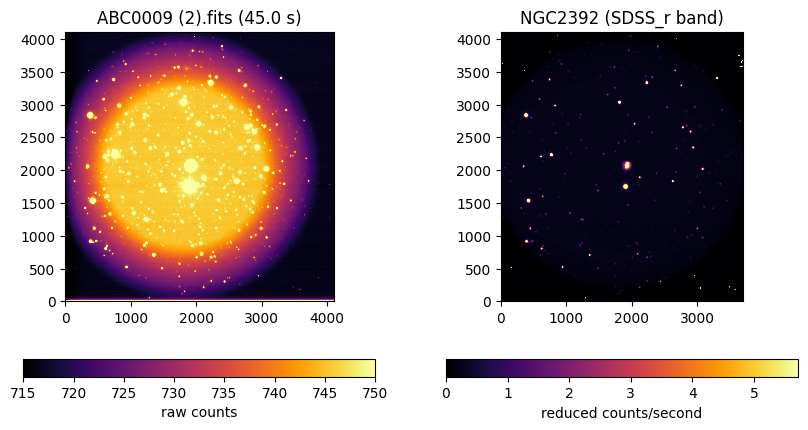

Opening ABC0007 (2).fits
ABC0007 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_r/ABC0007 (2).fits


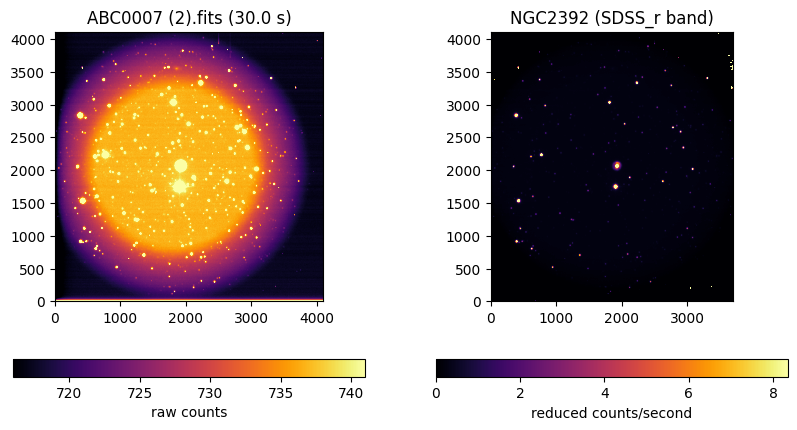

Opening ABC0008 (2).fits
ABC0008 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_r/ABC0008 (2).fits


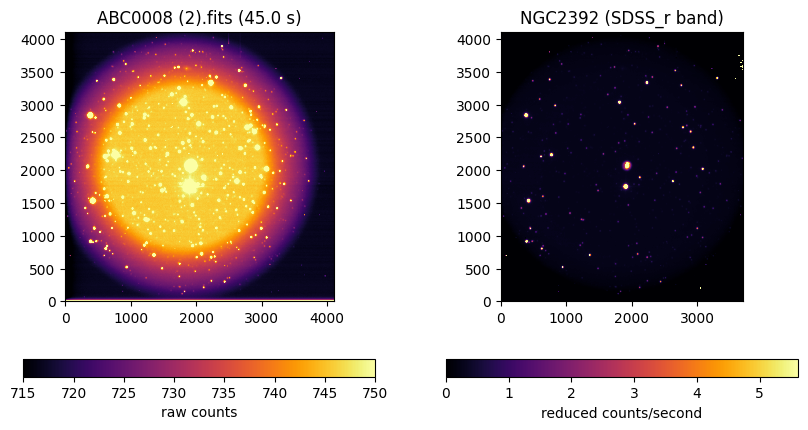

Opening ABC0011 (2).fits
ABC0011 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_i/ABC0011 (2).fits


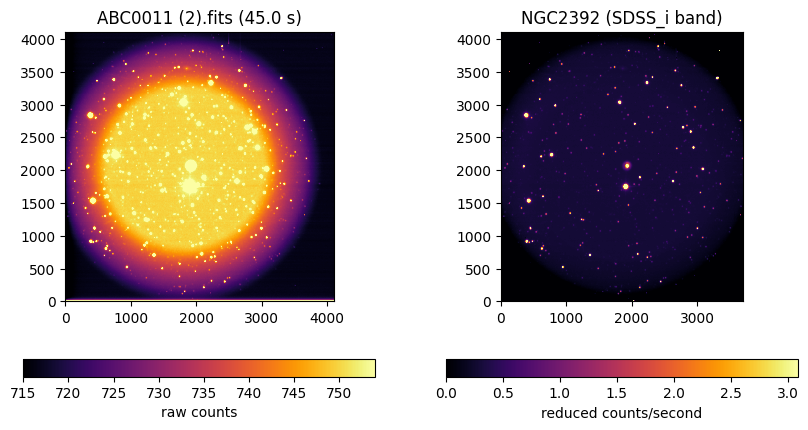

Opening ABC0010 (2).fits
ABC0010 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_i/ABC0010 (2).fits


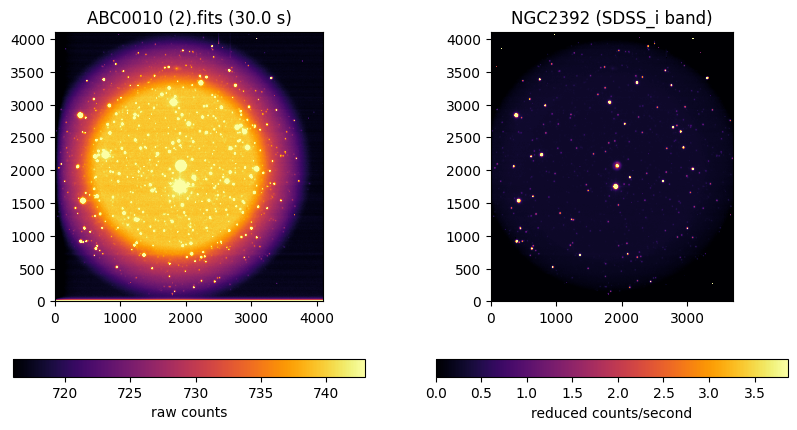

Opening ABC0012 (2).fits
ABC0012 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SDSS_i/ABC0012 (2).fits


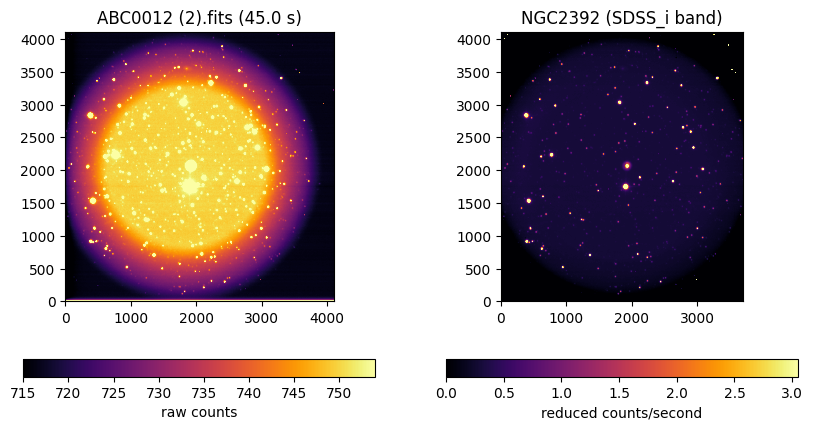

Opening ABC0013 (2).fits
ABC0013 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Hb/ABC0013 (2).fits


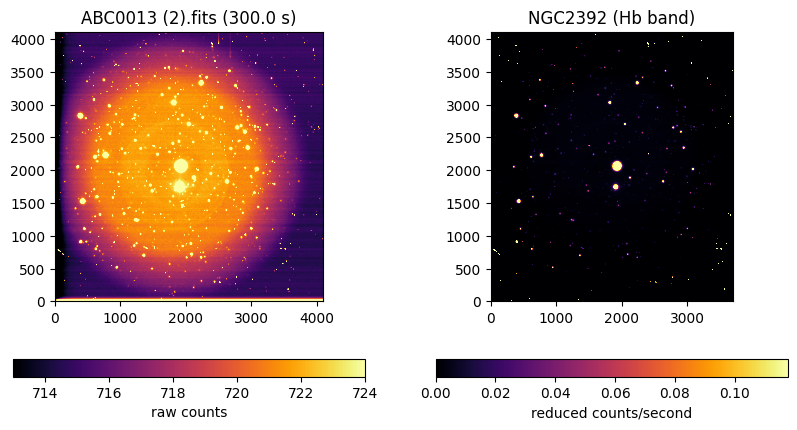

Opening ABC0016 (2).fits
ABC0016 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Hb/ABC0016 (2).fits


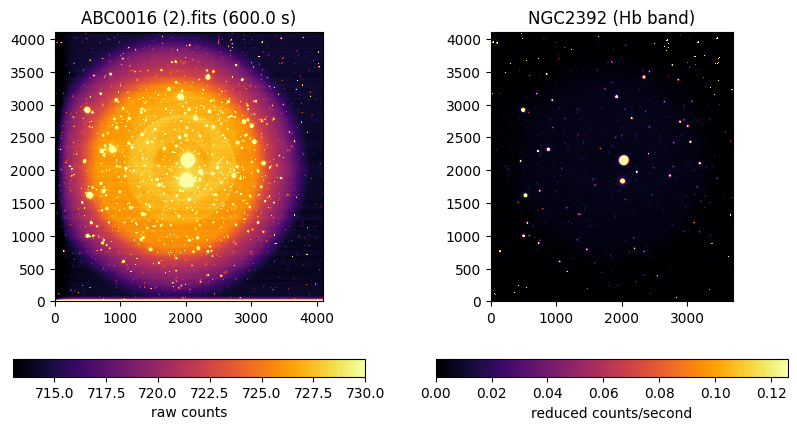

Opening ABC0015 (2).fits
ABC0015 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Hb/ABC0015 (2).fits


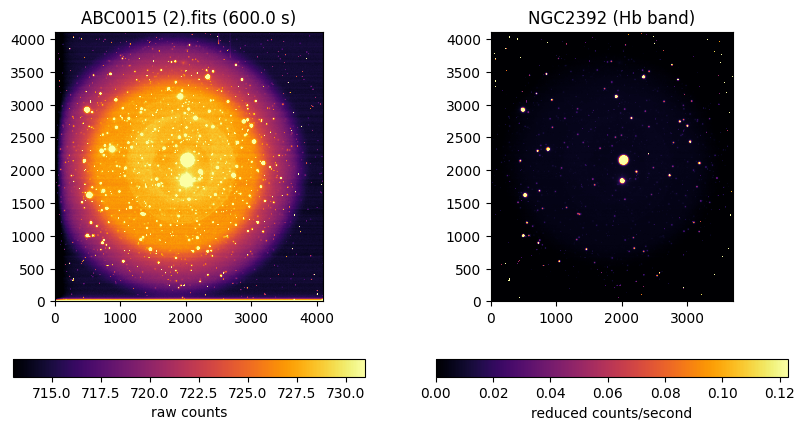

Opening ABC0014 (2).fits
ABC0014 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Hb/ABC0014 (2).fits


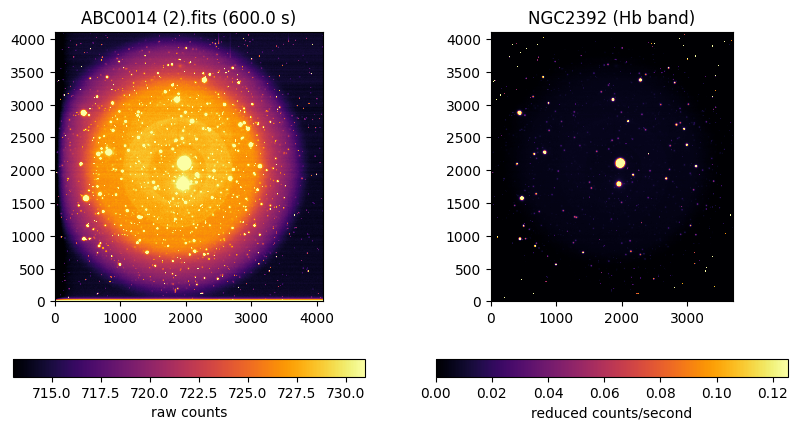

Opening ABC0017 (2).fits
ABC0017 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Ha/ABC0017 (2).fits


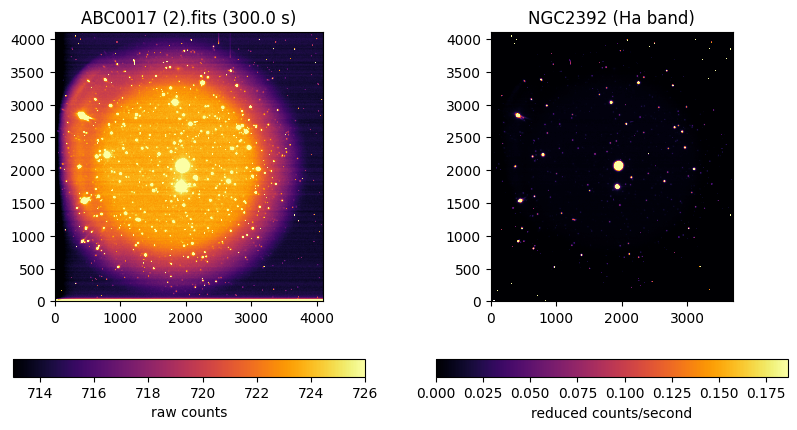

Opening ABC0018 (2).fits
ABC0018 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Ha/ABC0018 (2).fits


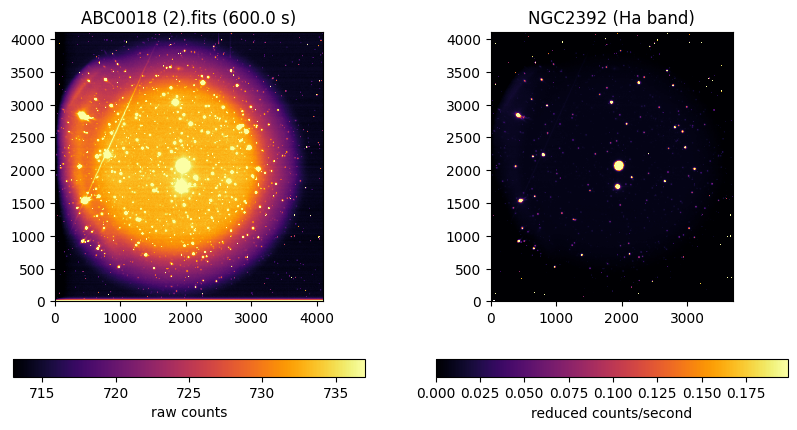

Opening ABC0019 (2).fits
ABC0019 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/Ha/ABC0019 (2).fits


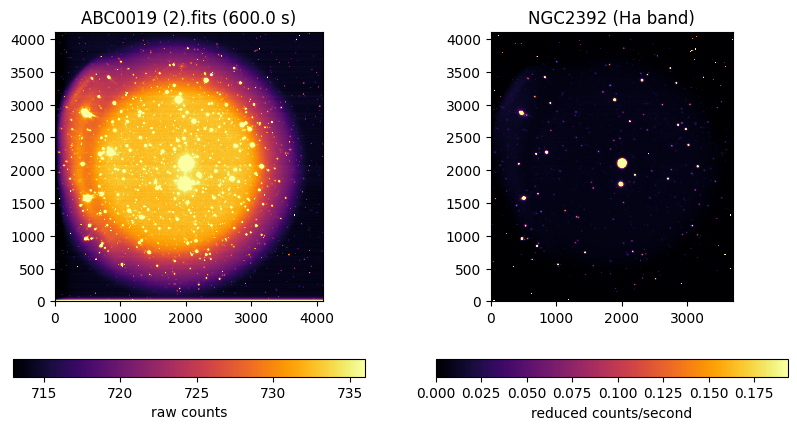

Opening ABC0026 (2).fits
ABC0026 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/HeI/ABC0026 (2).fits


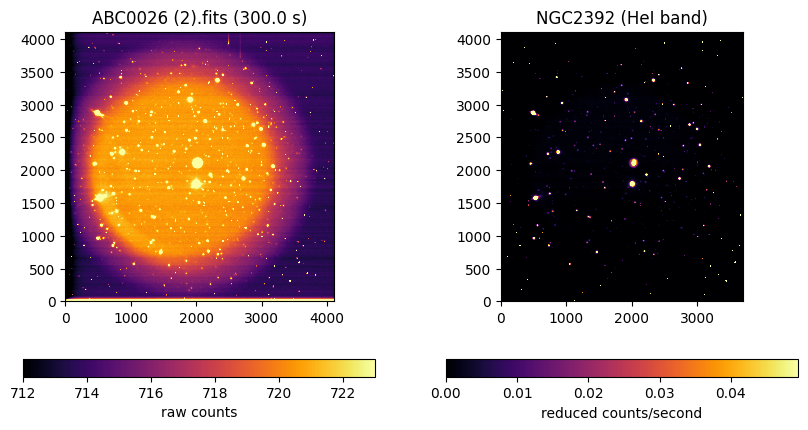

Opening ABC0027 (2).fits
ABC0027 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/HeI/ABC0027 (2).fits


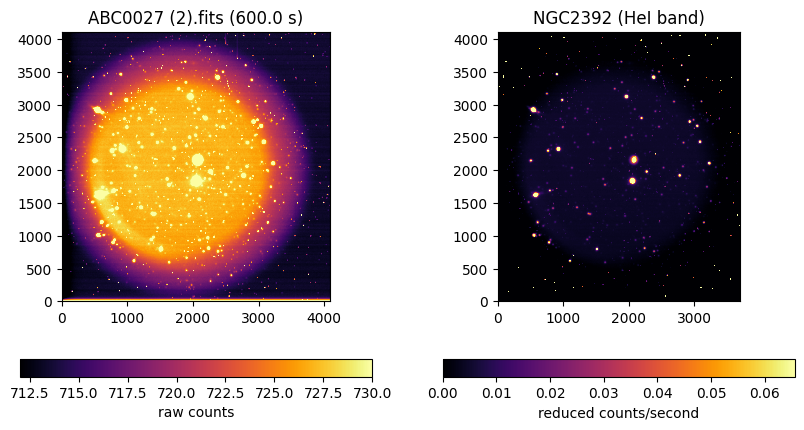

Opening ABC0028 (2).fits
ABC0028 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/HeI/ABC0028 (2).fits


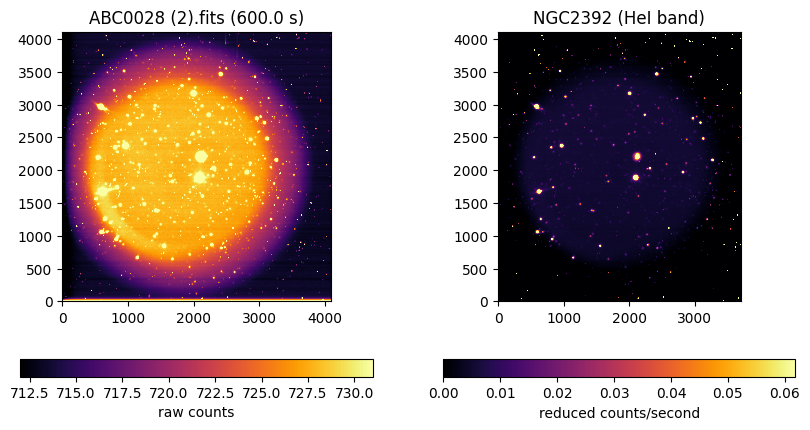

Opening ABC0024 (2).fits
ABC0024 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SII/ABC0024 (2).fits


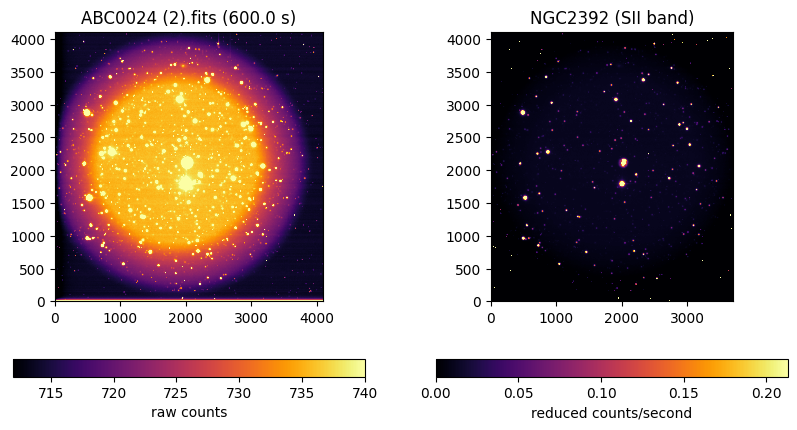

Opening ABC0023 (2).fits
ABC0023 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SII/ABC0023 (2).fits


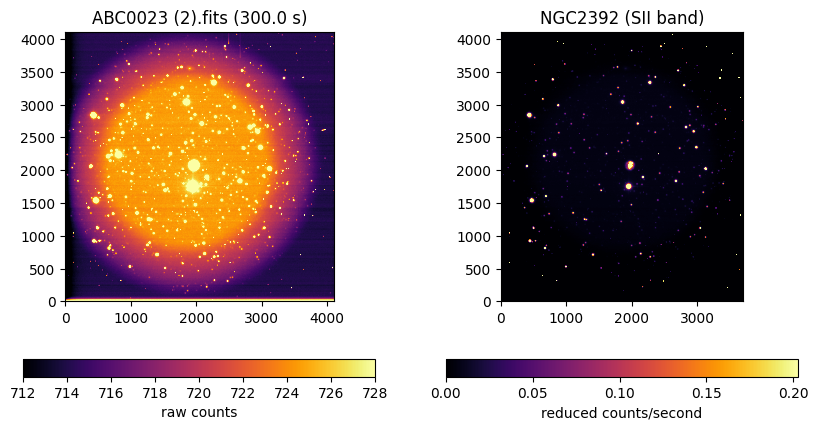

Opening ABC0025 (2).fits
ABC0025 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/SII/ABC0025 (2).fits


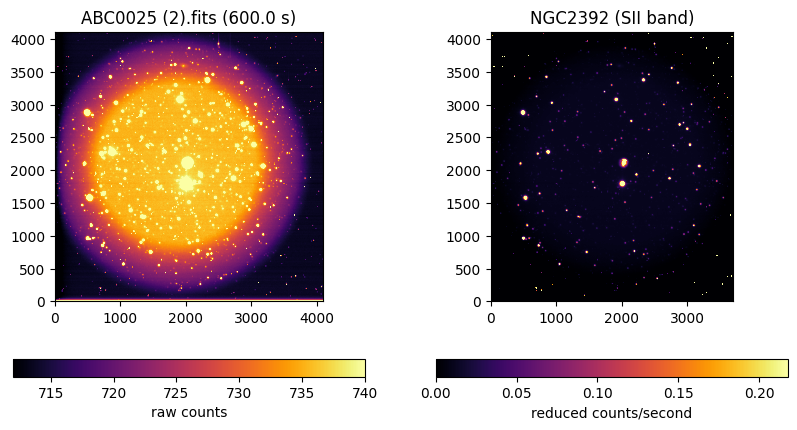

Opening ABC0021 (2).fits
ABC0021 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/OIII/ABC0021 (2).fits


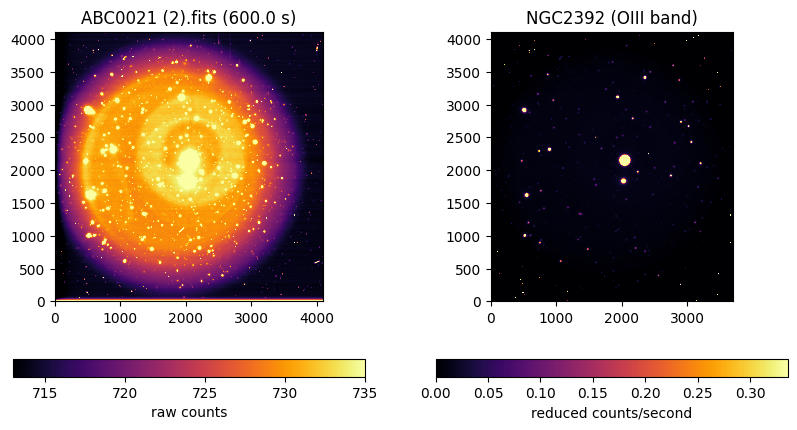

Opening ABC0022 (2).fits
ABC0022 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/OIII/ABC0022 (2).fits


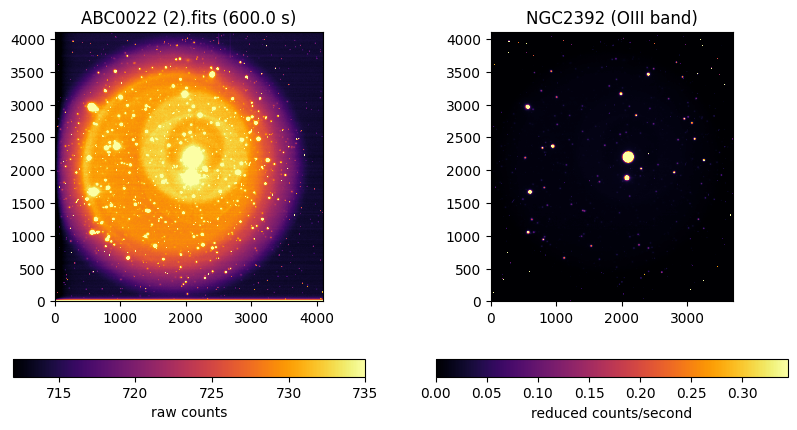

Opening ABC0020 (2).fits
ABC0020 (2).fits saved to  /content/drive/MyDrive/TOAFINAL/reduced/NGC2392/OIII/ABC0020 (2).fits


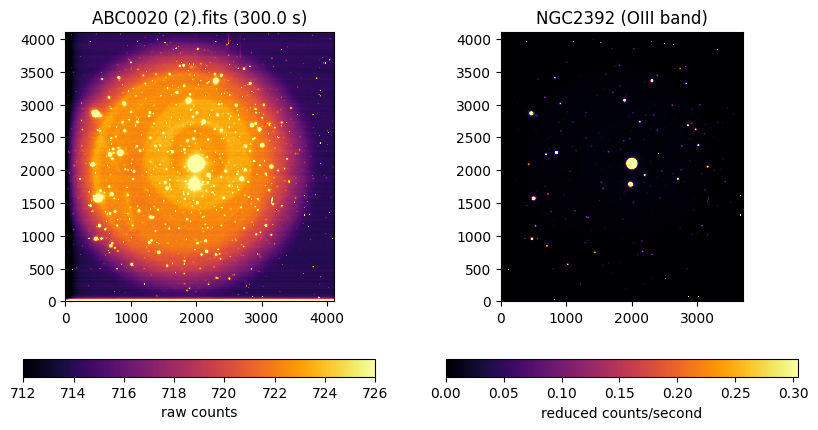

In [7]:
dark=0
##reading the master bias
bias_output_filename='master_bias.fits'

if os.path.exists(os.path.join(bias_folder,bias_output_filename)): #reading the master bias
  hdu=fits.open(os.path.join(bias_folder,bias_output_filename))
  bias=hdu[0].data
else:
  bias=0
  print('Master bias not found, setting bias to zero')
##reading the master flats
science_filter_list=['SDSS_g','SDSS_r','SDSS_i','Hb','Ha','HeI','SII','OIII'] #list of all the filters where you observed
flat={} #dictionary for later
for filter in science_filter_list: #loop over filters
  mflat_name=os.path.join(calib_folder, 'master_flat_'+filter+'.fits')
  if os.path.exists(mflat_name): #if there actually is a master flat in that filter, open
    hdu = fits.open(mflat_name)
    flat[filter]=hdu[0].data
    print('Read master flat for', filter, ' band')
  else: #if there isn't a master flat, set to 1
    print('Master flat in ',filter,' band not found, setting equal to 1')
    flat[filter]=1

#this now is for just 1 object, in case you want to do it for many just make a loop over object_name and check inside each object's folder
object_name='NGC2392'
object_path=os.path.join(data_folder,'raw','science',object_name)
for filter in science_filter_list:
  for filename in os.listdir(os.path.join(object_path,filter)):  # loop over all files in each flat
    print("Opening", filename)
    hdu = fits.open(os.path.join(os.path.join(object_path,filter), filename))  #get the raw exposure
    raw = hdu[0].data
    reduced = ((raw - bias)/hdu[0].header['EXPTIME'] - dark) / flat[filter] #do the actual reduction
    output_filename = os.path.join(output_folder, object_name, filter, filename) 
    os.makedirs(os.path.join(output_folder, object_name, filter), exist_ok=True) #making the folders in the reduced folder automatically, exist_ok checks if it already exists
    fits.writeto(output_filename, reduced, hdu[0].header, overwrite=True) #save the reduced data to the desired location
    print(filename, 'saved to ', output_filename)
    ##Plots of raw vs reduced
    fig = plt.figure(figsize=(10, 5))
    ax = fig.subplots(ncols=2) #2 subplots
    ax[0].set_title(f'{filename} ({hdu[0].header["EXPTIME"]} s)') #filename and exptime in one subplot, the actual object in the reduced
    im = ax[0].imshow(raw,origin='lower', vmin=np.nanpercentile(raw, 5), vmax=np.nanpercentile(raw, 95), cmap='inferno')
    
    #IMPORTANT: the flats being really low values in the edges of the image (and raw-bias having negative values sometimes, must be an artifact of taking the calibration on a different day, i guess)
    #made the edges have really high negative values after dividing, so i just truncated the colorbar and the plot of the reduced image, this way we can see the object, i don't really know how to fix it
    #i tried running this with other data and it seemed to do the reduction just fine, so i'll assume it's a thing with these flats
    cb = fig.colorbar(im, ax=ax[0], orientation='horizontal') #colorbar
    cb.ax.set_xlabel('raw counts') #label for the colorbar
        
    ax[1].set_title(f'{object_name} ({filter} band)') #same as the other one
    im = ax[1].imshow(reduced[:,:3700], origin='lower', vmin=0, vmax=np.nanpercentile(reduced[:,:3700], 99.5), cmap='inferno') 
    #Can tweak the percentiles to change the plot a little bit
    cb = fig.colorbar(im, ax=ax[1], orientation='horizontal')
    cb.ax.set_xlabel('reduced counts/second')
    plt.savefig(str(output_filename)+'.png')
    plt.show()